In [1]:
mErde, mOzean, RErde, mMond, rMondBahn, TMondBahn, G = 5.9721986*10**24, 0.0014*10**24, 6.3675*10**6, 7.3459*10**22, 3.836*10**8, 27.32166140*24*3600, 6.67430*10**(-11)
TErdRotation = 86164.100        # s           : Heutige Periodendauer der intrinsischen Erdrotation
tau = 0.0021                    # s/100a      : Zunahme der Tageslänge auf der Erde in 100 Jahren

import numpy as np
import matplotlib.pyplot as plt
import math
import sympy
from scipy.constants import pi
import scipy
from scipy.integrate import solve_ivp
from scipy.integrate._ivp.ivp import OdeResult # :) https://github.com/scipy/scipy/blob/main/scipy/integrate/_ivp/ivp.py
from matplotlib.animation import FuncAnimation
from IPython.display import Image #to display animations

# Beautiful plots
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "Computer Modern Roman"

# Useful StackPosts
# https://stackoverflow.com/questions/59634279/solve-ivp-error-required-step-size-is-less-than-spacing-between-numbers

# Executing everything all the time takes too long
fastExecution = True

In [12]:
# NICHT ANFASSEN! WENN DANN UNBEDINGT IN FINAL AUCH ÄNDERN!
def baryzentrum(m1, m2, r): return r*m2/(m1+m2)

def tide_acceleration(x_M, y_M, x_i, y_i, phi_i, ax_E, ay_E, omega_i, m_M):
    part_a, part_b = G*m_M* ((y_M - y_i)*np.cos(phi_i) - (x_M - x_i)*np.sin(phi_i)) / ((x_M - x_i)**2 + (y_M - y_i)**2)**(3/2), (RErde*omega_i**2 - (ax_E*np.cos(phi_i) + ay_E*np.sin(phi_i)))
    ax_i, ay_i = -part_a*np.sin(phi_i) - part_b*np.cos(phi_i), part_a*np.cos(phi_i) - part_b*np.sin(phi_i)
    return (-(ax_i - ax_E)*np.sin(phi_i) + (ay_i - ay_E)*np.cos(phi_i))/RErde

def eq_motion_4body(t, state, mass):
    x_E, y_E, x_M, y_M, phi_1, phi_2, vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2 = state
    m_E, m_M, m_1, m_2 = mass
    x_1, y_1, x_2, y_2 = x_E + RErde*np.cos(phi_1), y_E + RErde*np.sin(phi_1), x_E + RErde*np.cos(phi_2), y_E + RErde*np.sin(phi_2)
    mu_x = m_E + m_1*np.cos(phi_1)**2 + m_2*np.cos(phi_2)**2
    mu_y = m_E + m_1*np.sin(phi_1)**2 + m_2*np.sin(phi_2)**2
    a = (G*m_M*m_E)/((x_M - x_E)**2 + (y_M - y_E)**2)**(3/2)
    b = m_1*np.sin(phi_1)*np.cos(phi_1) + m_2*np.sin(phi_2)*np.cos(phi_2)
    c1 = m_1*RErde*omega_1**2 + (G*m_M*m_1*((x_M - x_1)*np.cos(phi_1) + (y_M - y_1)*np.sin(phi_1)))/((x_M - x_1)**2 + (y_M - y_1)**2)**(3/2)
    c2 = m_2*RErde*omgea_2**2 + (G*m_M*m_2*((x_M - x_2)*np.cos(phi_2) + (y_M - y_2)*np.sin(phi_2)))/((x_M - x_2)**2 + (y_M - y_2)**2)**(3/2)    
    ax_E = 1/(mu_x - b**2/mu_y) * (a*(x_M - x_E) -b/mu_y*(a*(y_M - y_E) + c1*np.sin(phi_1) + c2*np.sin(phi_2)) + c1*np.cos(phi_1) + c2*np.cos(phi_2))
    ay_E = 1/mu_y*(a*(y_M - y_E) - b*ax_E + c1*np.sin(phi_1) + c2*np.sin(phi_2))
    ax_M = G*((m_E*(x_E - x_M))/((x_E - x_M)**2 + (y_E - y_M)**2)**(3/2) + (m_1*(x_1 - x_M))/((x_1 - x_M)**2 + (y_1 - y_M)**2)**(3/2) + (m_2*(x_2 - x_M))/((x_2 - x_M)**2 + (y_2 - y_M)**2)**(3/2))
    ay_M = G*((m_E*(y_E - y_M))/((x_E - x_M)**2 + (y_E - y_M)**2)**(3/2) + (m_1*(y_1 - y_M))/((x_1 - x_M)**2 + (y_1 - y_M)**2)**(3/2) + (m_2*(y_2 - y_M))/((x_2 - x_M)**2 + (y_2 - y_M)**2)**(3/2))
    alpha_1, alpha_2 = tide_acceleration(x_M, y_M, x_1, y_1, phi_1, ax_E, ay_E, omega_1, m_M), tide_acceleration(x_M, y_M, x_2, y_2, phi_2, ax_E, ay_E, omgea_2, m_M) 
    return[vx_E, vy_E, vx_M, vy_M, omega_1, omgea_2, ax_E, ay_E, ax_M, ay_M, alpha_1, alpha_2]

def center_of_mass(mass, position_x , position_y):
    return [np.sum(mass*position_x)/np.sum(mass), np.sum(mass*position_y)/np.sum(mass)]

def iv_stable_orbit_4body():
    mass = [mErde, mMond, mOzean/2, mOzean/2] # Each of the tides gets half of the ocean's mass
    abstand_baryzentrum_erde = center_of_mass(mass, np.array([0, rMondBahn, -RErde, RErde]), np.array([0, 0, 0, 0]))[0]
    x0_Erde = [-abstand_baryzentrum_erde, 0]
    x0_Mond = [rMondBahn - abstand_baryzentrum_erde, 0]
    vy0_Erde = 2*pi*abstand_baryzentrum_erde/TMondBahn
    vy0_Mond = 2*pi*(rMondBahn-abstand_baryzentrum_erde)/TMondBahn
    v0_Erde = [0, -vy0_Erde]
    v0_Mond = [0, vy0_Mond]
    phi_1, phi_2 = 0, pi
    omega_1, omega_2 = 2*pi/TMondBahn, 2*pi/TMondBahn 
    return [x0_Erde, x0_Mond, [phi_1, phi_2], v0_Erde, v0_Mond, [omega_1, omega_2], mass]

def four_body_problem(pos_body_1: list, pos_body_2: list, phi_i: list, vel_body_1: list, vel_body_2: list, omega_i: list, mass: list, t_max: float, fun=eq_motion_4body, steps=1, method='RK45', t_start=0):
    solution = solve_ivp(fun=fun, t_span=[t_start, t_max], y0=[*pos_body_1, *pos_body_2, *phi_i, *vel_body_1, *vel_body_2, *omega_i], args=(mass,), rtol=1e-12, atol=1e-12)
    x_E, y_E, x_M, y_M, phi_1, phi_2, vx_E, vy_E, vx_M, vy_M, omega_1, omega_2 = solution.y
    return [solution.t, x_E, y_E, x_M, y_M, phi_1, phi_2]

#### Custom Mathjax Befehle
Wenn ihr auch Lust habt damit rumzuspielen, man kann in Mathjax neue Commands erstellen ;)
$\newline$
Hier sind alle die ich bis jetzt gemacht habe (sieht man nicht).
$ \def\dv#1{ \frac{\mathrm{d}}{\mathrm{d} #1} } $
$ \def\dd#1{ \ \mathrm{d} #1 } $
$ \def\Vec#1{ \overrightarrow{#1} } $ Aus dem Physics package.
$ \def\VecT#1#2{ \begin{pmatrix} #1 \\ #2 \end{pmatrix} } $ 2D Vector
$ \def\VecD#1#2#3{ \begin{pmatrix} #1 \\ #2 \\ #3 \end{pmatrix} } $ 2D Vector
$ \def\VecE#1{ \hat{e}_{#1} } $ Einheitsvektor
Hier ein schöner StackExchange [Post](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference/11638#11638) dazu 

$\providecommand{\e}[1]{\ensuremath{\cdot 10^{#1}}}$ mit \e-9 kann man normale Scientific notation machen
$\providecommand{\fehlt}{\textcolor{red}{\textbf{Fehlt!\dots}}}$ benutze ich gerne in meinen LateX Dokumenten
$\providecommand{\todo}{\textcolor{red}{\textbf{\huge{ToDo}}}}$ benutze ich gerne in meinen LateX Dokumenten wenn noch was gemacht werden soll

#### Variablenbennung
Ich bin für:
$\newline$
$x_{\text{Anfangsbuchstabe des Körpers}} $ im Code `x_{Anfangsbuchstabe des Körpers}`
$\newline$
$vx_{\text{Anfangsbuchstabe des Körpers}} $, im Code `vx_{Anfangsbuchstabe des Körpers}`
$\newline$
$ax_{\text{Anfangsbuchstabe des Körpers}} $, im Code `ax_{Anfangsbuchstabe des Körpers}`
$\newline$
Für Winkel:
$\newline$
$\phi_{\text{Anfangsbuchstabe des Körpers}} $ im Code `phi_{Anfangsbuchstabe des Körpers}`
$\newline$
Für Winkelgeschwindigkeit:
$\newline$
$\omega_{\text{Anfangsbuchstabe des Körpers}} $ im Code `omega_{Anfangsbuchstabe des Körpers}`
$\newline$
Für Winkelbeschleunigung:
$\newline$
$\alpha_{\text{Anfangsbuchstabe des Körpers}} $ im Code `alpha_{Anfangsbuchstabe des Körpers}`
$\newline$
State Vektor:
$\newline$
Erst alle Positionen, dann alle Geschwindigkeiten, dann alle Beschleunigungen.
Postionen und Winkel gemischt und selbe Reihenfolge, möglichst nach Objekt grupiert. Konstanten am Schluss.

#### Zweikörperproblem

- Lösen Sie mit Ihren Implementierungen die Bewegungsgleichungen des Erde-Mond-Systems erneut. Vergleichen Sie die Ergebnisse untereinander und mit dem Ergebnis der obigen Funktion. Vergleichen Sie alle Ergebnisse auch mit der exakten Lösung des Zweikörperproblems.

In [3]:
# TODO: Solve the DGL and visualize the solution better, so that we can see the differences!
# TODO: write down the differences between the two methods and the exact solution!!

Vierkörperproblem:

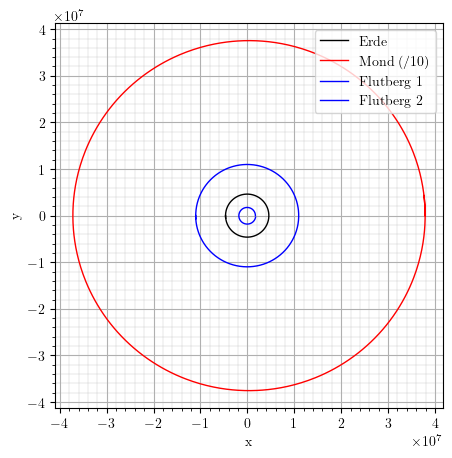

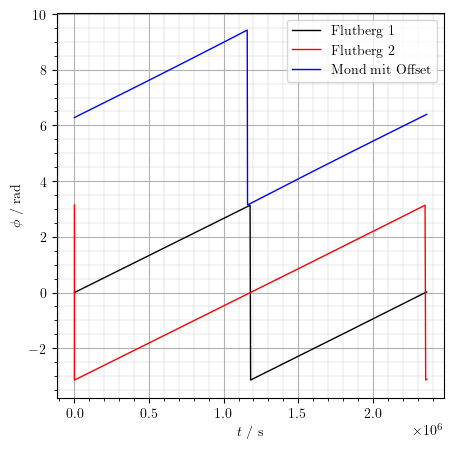

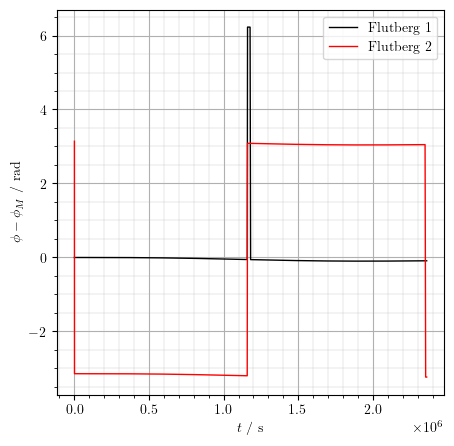

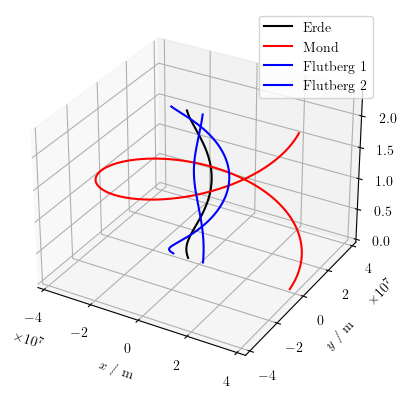

In [4]:
t, x_E, y_E, x_M, y_M, phi_1, phi_2 = four_body_problem(*iv_stable_orbit_4body(), TMondBahn)

x_1, y_1 = x_E + RErde*np.cos(phi_1), y_E + RErde*np.sin(phi_1)
x_2, y_2 = x_E + RErde*np.cos(phi_2), y_E + RErde*np.sin(phi_2)

plt.rc('axes', axisbelow=True)
plt.figure(figsize=(5, 5))
plt.grid('minor', 'minor', linestyle='-', linewidth=0.2)
plt.grid('major', 'major', linestyle='-', linewidth=0.8)
plt.minorticks_on()
plt.xlabel("x")
plt.ylabel("y")

plt.plot(x_E, y_E, 'k', linewidth=1, label='Erde')
plt.plot(x_M/10, y_M/10, 'r', linewidth=1, label='Mond (/10)')
plt.plot(x_1, y_1, 'b', linewidth=1, label='Flutberg 1')
plt.plot(x_2, y_2, 'b', linewidth=1, label='Flutberg 2')

plt.legend()
plt.show()
plt.close()

# Plot the change of the center of mass over time
# fig, ax = plt.subplots()
# fig.set_label("Bewegung des Baryzentrum des Erde-Mond-Systems")
# ax.plot(t, center_of_mass(mErde, mMond, mOzean/2, mOzean/2, x_E, y_E, x_M, y_M, x_1, y_1, x_2, y_2)[0], color='blue', label='x-Koordinate des Schwerpunkts')
# ax.plot(t, center_of_mass(mErde, mMond, mOzean/2, mOzean/2, x_E, y_E, x_M, y_M, x_1, y_1, x_2, y_2)[1], color='red', label='y-Koordinate des Schwerpunkts')
# ax.set_xlabel('Zeit $t$ / s')
# ax.set_ylabel('Position $x$ / m')
# ax.set_title('Baryzentrum')
# ax.legend()
# plt.show()
# plt.close()

# Plot the angles of the tides over time

# Normalize the angles to the range -π to π
normalized_angles_phi_1 = np.remainder(phi_1, 2 * np.pi)
normalized_angles_phi_1 = np.where(normalized_angles_phi_1 > np.pi, normalized_angles_phi_1 - 2 * np.pi, normalized_angles_phi_1)
normalized_angles_phi_2 = np.remainder(phi_2, 2 * np.pi)
normalized_angles_phi_2 = np.where(normalized_angles_phi_2 > np.pi, normalized_angles_phi_2 - 2 * np.pi, normalized_angles_phi_2)

plt.rc('axes', axisbelow=True)
plt.figure(figsize=(5, 5))
plt.grid('minor', 'minor', linestyle='-', linewidth=0.2)
plt.grid('major', 'major', linestyle='-', linewidth=0.8)
plt.minorticks_on()
plt.xlabel("$t$ / s")
plt.ylabel("$\phi$ / rad")

plt.plot(t, normalized_angles_phi_1, 'k', linewidth=1, label='Flutberg 1')
plt.plot(t, normalized_angles_phi_2, 'r', linewidth=1, label='Flutberg 2')
plt.plot(t, np.arctan2(y_M, x_M) + 2*pi, 'b', linewidth=1, label='Mond mit Offset')

plt.legend()
plt.show()
plt.close()

# Plot the angles of the tides over time, subtracting the angle of the moon
plt.rc('axes', axisbelow=True)
plt.figure(figsize=(5, 5))
plt.grid('minor', 'minor', linestyle='-', linewidth=0.2)
plt.grid('major', 'major', linestyle='-', linewidth=0.8)
plt.minorticks_on()
plt.xlabel("$t$ / s")
plt.ylabel("$\phi - \phi_M$ / rad")

plt.plot(t, normalized_angles_phi_1 - np.arctan2(y_M, x_M), 'k', linewidth=1, label='Flutberg 1')
plt.plot(t, normalized_angles_phi_2 - np.arctan2(y_M, x_M), 'r', linewidth=1, label='Flutberg 2')

plt.legend()
plt.show()
plt.close()

# Plot a 3d phase space diagram
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.plot(x_E, y_E, t, 'k', label='Erde')
ax.plot(x_M/10, y_M/10, t, 'r', label='Mond')
ax.plot(x_1, y_1, t, 'b', label='Flutberg 1')
ax.plot(x_2, y_2, t, 'b', label='Flutberg 2')
ax.set_xlabel("$x$ / m")
ax.set_ylabel("$y$ / m")
ax.set_zlabel("$t$ / s")
ax.legend()
plt.show()
plt.close()

# Animation of the four body problem #
if not fastExecution: # Don't render if not necessary
    fig = plt.figure(figsize=(5, 5)) # Square figure, so the circles are actually circles
    ax = plt.axes(xlim=(-4e8, 4e8), ylim=(-4e8, 4e8))
    earth_line, = ax.plot([], [], marker='o', lw=0.1, color='blue', label='Erde (*10)')
    moon_line, = ax.plot([], [], marker='o', lw=0.1, color='red', label='Mond')
    tide_1_line, = ax.plot([], [], marker='o', lw=0.1, color='green', label='Flutberg 1 (*10)')
    tide_2_line, = ax.plot([], [], marker='o', lw=0.1, color='violet', label='Flutberg 2 (*10)')
    ax.legend()

    def animate(i):
        earth_line.set_data([x_E[i]*10], [y_E[i]*10])
        moon_line.set_data([x_M[i]], [y_M[i]])
        tide_1_line.set_data([x_1[i]*10], [y_1[i]*10])
        tide_2_line.set_data([x_2[i]*10], [y_2[i]*10])
        return earth_line, moon_line

    anim = FuncAnimation(fig, animate, init_func=None, frames=t.shape[0], interval=30, blit=True)
    anim.save('Erde_Mond_Flutberge.gif', writer='pillow')
    plt.close()

# display(Image(data=open('Erde_Mond_Flutberge.gif','rb').read(), format='png'))

#### Vierkörperproblem mit Randbedingungen, intrinsischer Rotation und Reibung

- Erweitern Sie Ihre Funktion abermals und berücksichtigen Sie nun auch die Reibung zwischen den Flutbergen und dem übrigen Teil der Erde sowie die intrinsische Rotation der Erde, welche sich durch die Reibungskraft $\vec F_{\mathrm R}$ ändert.
    - Verwenden Sie als Reibungskraft, die auf den i-ten Flutberg wirkt, $ \vec F_{\mathrm R,i}(\vec v_i)=-km_i|\vec v_i| \vec v_i\,,$ hierbei ist $\vec v_i$ die Geschwindigkeit des $i$-ten Flutbergs relativ zur rotierenden Erdoberfläche und $k$ eine effektive Reibungskonstante. Wählen Sie im Folgenden $k=2\cdot10^{-12}\,\frac{1}{\mathrm m}$.
    - Leiten Sie die Bewegungsgleichung für die intrinsische Erdrotation aus der Drehimpulsrelation $L=I \omega$ her. Hierbei ist $\omega$ die Winkelgeschwindigkeit der Eigenrotation und $I$ das Trägheitsmoment der Erde, wobei die Erde diesbezüglich als Kugel mit homogener Massenverteilung betrachtet werden soll (in den anderen Bewegungsgleichungen aber weiterhin als Punktmasse). Geben Sie die Beziehung zwischen dem auf die Erde wirkenden Drehmoment $M$ und der Zeitableitung $\dot\omega$ an, die daraus folgt. Bestimmen Sie $M$ aus den Reibungskräften, um daraus die Bewegungsgleichung für die intrinsische Erdrotation zu erhalten.
    - Zusätzlich müssen Sie die Bewegungsgleichungen der Flutberge anpassen, indem Sie die entsprechende Reibungskraft in die Kräftgleichung mit einbauen.
$\newline$
- Betrachten Sie wieder die zeitliche Entwicklung des Vierteilchensystems und erstellen Sie eine Grafik/Animation der beteiligten Körper in Abhängigkeit der Zeit und in der $x$-$y$-Ebene. Vergleichen Sie die Bewegung der Flutberge mit und ohne Reibung. Illustrieren Sie einen möglichen Unterschied beider Bewegungen.
$\newline$
- Modifizieren Sie die Massen der Flutberge so, dass die aktuelle Zunahme der Tageslänge pro 100 Jahre mit dem oben angegebenen Literaturwert $\tau$ übereinstimmt. Weichen die modifizierten Massen der Flutberge von der Masse der Ozeane ab? Geben Sie mögliche Gründe für die Abweichungen an.
    - Wählen Sie die Massen der beiden Flutberge gleich groß. Falls Sie die Flutberge wieder auf der Verbindungslinie zwischen Erde und Mond mit der Umlaufperiodendauer des Mondes starten lassen, berücksichtigen Sie die Einschwingzeit des Systems, bevor Sie die Tageslängenänderung bestimmen.

#### Herleitung der zusätzlichen Bewegungsgleichung und der Reibungskraft

Wir wollen als erstes die Reibungskraft bestimmen:
$ \vec F_{\mathrm R,i}(\vec v_i)=-km_i|\vec v_i| \vec v_i\,$

Die Geschwindigkeits des Flutbergs bestimmen wir über seine Winkelgeschwindikeit relativ zur Erdoberfläche $(\omega_E - \omega_i)$.
Mit dieser dreht er sich um die z-Achse.

Die Geschwindigkeit ist definiert als $\vec v_i = \vec \omega_i \times \vec r_i$.
Wir setzen ein:
\begin{equation*}
    \vec v_i = (\omega_E - \omega_i) \cdot \VecD{0}{0}{1} \times r_{E} \cdot \vec e_{r, i} = \VecD{0}{0}{\omega_E - \omega_i} \times \VecD{r_{E} \cdot \cos(\phi_i)}{r_{E} \cdot \sin(\phi_i)}{0} = \VecD{-r_{E} \cdot \sin(\phi_i) \cdot (\omega_E - \omega_i)}{r_{E} \cdot \cos(\phi_i) \cdot (\omega_E - \omega_i)}{0}
\end{equation*}
Damit rechnen wir den Betrag aus:
\begin{equation*}
    |\vec v_i| = \sqrt{r_{E}^2 \cdot (\omega_E - \omega_i)^2 \cdot \sin^2(\phi_i) + r_{E}^2 \cdot (\omega_E - \omega_i)^2 \cdot \cos^2(\phi_i)} = r_{E} \cdot |\omega_E - \omega_i|
\end{equation*}
Also ist die Reibungskraft:
\begin{equation*}
    \vec F_{\mathrm R,i}(\vec v_i)
    = -km_i |\vec v_i| \vec v_i
    = -km_i r_{E} \cdot |\omega_E - \omega_i| \cdot \VecD{-r_{E} \cdot \sin(\phi_i) \cdot (\omega_E - \omega_i)}{r_{E} \cdot \cos(\phi_i) \cdot (\omega_E - \omega_i)}{0} 
    = -km_i r_{E}^2 \cdot |\omega_E - \omega_i|(\omega_E - \omega_i) \cdot \VecD{- \sin(\phi_i)}{\cos(\phi_i)}{0}
\end{equation*}
Diese Teilen wir durch die Masse des i.ten Flutbergs um die Beschleuningung zu erhalten. Wir addieren sie dann einfach auf die Differentialgleichung des i.ten Flutbergs aus dem 4-Körper-Problem.

Als nächstes wollen wir die Differentialgleichung für die intrinsische Rotation der Erde herleiten.
Wir wissen, dass die Drehimpulsrelation $L = I \cdot \omega$ gilt.
Wir nehmen die Erde als Kugel mit homogener Massenverteilung an, damit hat sie ein Trägheitsmoment von $I = \frac{2}{5} m_E r_E^2$.
Damit hat sie einne Drehimpulsund ein Drehmoment von:
\begin{gather*}
    \vec L = \frac{2}{5} m_E r_E^2 \vec \omega \\
    \vec M = \frac{\mathrm d \vec L}{\mathrm d t} = \frac{2}{5} m_E r_E^2 \vec{\dot \omega}
\end{gather*}
Das Drehmoment was durch die Reibungskraft entsteht ist:
\begin{equation*}
    \vec M_{\mathrm R} = \sum_{i=1}^2 \vec r_i \times \vec F_{\mathrm R,i}
\end{equation*}
Dies berechnet sich für zu:
\begin{equation*}
    \vec M_{\mathrm R} = \VecD{0}{0}{-k r_E^3 \left(m_1 \cdot |\omega_E - \omega_1|(\omega_E - \omega_1) + m_2 \cdot |\omega_E - \omega_2|(\omega_E - \omega_2) \right)}
\end{equation*}
Setzen wir die z-Komponenten gleich, erhalten wir:
\begin{gather*}
    \frac{2}{5} m_E r_E^2 \dot \omega_E = -k r_E^3 \left(m_1 \cdot |\omega_E - \omega_1|(\omega_E - \omega_1) + m_2 \cdot |\omega_E - \omega_2|(\omega_E - \omega_2) \right) \\
    \dot \omega_E = -\frac{5 k r_E}{2 m_E} \left(m_1 \cdot |\omega_E - \omega_1|(\omega_E - \omega_1) + m_2 \cdot |\omega_E - \omega_2|(\omega_E - \omega_2) \right)
\end{gather*}

In [10]:
k = 2*10**(-12)

def iv_stable_orbit_4body_friction():
    '''Initial conditions for the Earth-Moon-Tides system in a stable orbit'''
    x0_Erde, x0_Mond, phi_i, v0_Erde, v0_Mond, omega_i, mass = iv_stable_orbit_4body()
    phi0_E = 0 # The starting point of the earth's rotation is unconsequentially defined as 0
    omega0_E = 2*pi / TErdRotation # Angular velocity of the earth
    return [x0_Erde, x0_Mond, phi_i, phi0_E, v0_Erde, v0_Mond, omega_i, omega0_E, mass]

def tides_acceleration_friction(x_M, y_M, x_i, y_i, phi_i, ax_E, ay_E, omega_i, omega_E, m_M):
    '''Calculates the angular acceleration of a tide, using the equation above'''
    ax_friction = k * RErde**2 * np.abs(omega_i - omega_E)* (omega_i - omega_E) * np.sin(phi_i)
    ay_friction = -k * RErde**2 * np.abs(omega_i - omega_E)* (omega_i - omega_E) * np.cos(phi_i)
    part_a = G*m_M* ((y_M - y_i)*np.cos(phi_i) - (x_M - x_i)*np.sin(phi_i)) / ((x_M - x_i)**2 + (y_M - y_i)**2)**(3/2)
    part_b = (RErde*omega_i**2 - (ax_E*np.cos(phi_i) + ay_E*np.sin(phi_i)))
    ax_i = -part_a*np.sin(phi_i) - part_b*np.cos(phi_i) + ax_friction
    ay_i =  part_a*np.cos(phi_i) - part_b*np.sin(phi_i) + ay_friction

    alpha_i = (-(ax_i - ax_E)*np.sin(phi_i) + (ay_i - ay_E)*np.cos(phi_i))/RErde
    return alpha_i

def eq_motion_4body_friction(t, state, mass):
    x_E, y_E, x_M, y_M, phi_1, phi_2, phi_E, vx_E, vy_E, vx_M, vy_M, omega_1, omega_2, omega_E = state
    x_1, y_1, x_2, y_2 = x_E + RErde*np.cos(phi_1), y_E + RErde*np.sin(phi_1), x_E + RErde*np.cos(phi_2), y_E + RErde*np.sin(phi_2)
    m_E, m_M, m_1, m_2 = mass
    
    # Reuse the equations of motion from the 4-body problem for the earth and the moon:
    _, _, _, _, _, _, ax_E, ay_E, ax_M, ay_M, _, _ = eq_motion_4body(t, np.array([x_E, y_E, x_M, y_M, phi_1, phi_2, vx_E, vy_E, vx_M, vy_M, omega_1, omega_2]), mass)

    # Tides angular acceleration:
    alpha_1 = tides_acceleration_friction(x_M, y_M, x_1, y_1, phi_1, ax_E, ay_E, omega_1, omega_E, m_M)
    alpha_2 = tides_acceleration_friction(x_M, y_M, x_2, y_2, phi_2, ax_E, ay_E, omega_2, omega_E, m_M)

    # The earth's angular acceleration:
    alpha_E = (5*k*RErde)/(2*m_E) * (m_1*np.abs(omega_1 - omega_E)*(omega_1 - omega_E) + m_2*np.abs(omega_2 - omega_E)*(omega_2 - omega_E))

    return[vx_E, vy_E, vx_M, vy_M, omega_1, omega_2, omega_E, ax_E, ay_E, ax_M, ay_M, alpha_1, alpha_2, alpha_E]

def four_body_problem_friction(pos_body_1: list, pos_body_2: list, phi_i: list, phi_E:float, vel_body_1: list, vel_body_2: list, omega_i: list, omega_E: float, mass: list, t_max: float, steps=1, method='RK45', t_start=0):
    solution = solve_ivp(fun=eq_motion_4body_friction, t_span=[t_start, t_max], y0=[*pos_body_1, *pos_body_2, *phi_i, phi_E, *vel_body_1, *vel_body_2, *omega_i, omega_E], args=(mass,), rtol=1e-6, atol=1e-6)
    x_E, y_E, x_M, y_M, phi_1, phi_2, phi_E, vx_E, vy_E, vx_M, vy_M, omega_1, omega_2, omega_E = solution.y
    return [solution.t, x_E, y_E, x_M, y_M, phi_1, phi_2, phi_E, omega_1, omega_2, omega_E]

t, x_E, y_E, x_M, y_M, phi_1, phi_2, phi_E, omega_1, omega_2, omega_E = four_body_problem_friction(*iv_stable_orbit_4body_friction(), 100*365*24*3600) # 100 years

In [11]:
# TErdRotation = 86164.100        # s           : Heutige Periodendauer der intrinsischen Erdrotation
# tau = 0.0021                    # s/100a      : Zunahme der Tageslänge auf der Erde in 100 Jahren

# The change in the angular velocity
angular_velocity_change = (omega_E[0] - omega_E[-1])

# w = 2*pi/T -> T = 2*pi/w
rotation_period_at_start = (2*pi/omega_E[0])
rotation_period_at_end = (2*pi/omega_E[-1])
print(f'rotation_period_at_start: {rotation_period_at_start}, rotation_period_at_end: {rotation_period_at_end}')
print(f'rotation_period_at_start [h]: {rotation_period_at_start/3600}, rotation_period_at_end [h]: {rotation_period_at_end/3600}')

print(f'tau_lit: {tau}, tau_calc: {rotation_period_at_end - rotation_period_at_start}')

rotation_period_at_start: 86164.10000000002, rotation_period_at_end: 86301.1571399604
rotation_period_at_start [h]: 23.93447222222223, rotation_period_at_end [h]: 23.972543649989
tau_lit: 0.0021, tau_calc: 137.05713996037957


### Weiterführende Untersuchungen 

#### Variation der Reibungskonstante

- Können Sie die Reibungskonstante $k$ so fitten, dass die Gesamtmasse der Flutberge der Masse der Ozeane entspricht und auch $\tau$ mit dem Literaturwert übereinstimmt? Was beobachten Sie für diesen Fall im zeitlichen Verlauf?

#### Vielteilchenproblem mit Randbedingungen, intrinsischer Rotation und Reibung

- Verwenden Sie statt nur zwei Flutbergen nun eine Vielzahl von Punktmassen, die Sie auf der Erdoberfläche verteilen. Die Punktmassen simulieren nun die Wassermassen auf der Erdoberfläche. Können Sie die Ausprägung der beiden Flutberge beobachten?  Damit das Lösen der Differentialgleichungen nicht zu aufwändig wird, benötigen Sie eine Näherung. Nehmen Sie hierzu an, dass die Masse der Erde viel größer als die Masse der Flutberge ist. Ersetzen Sie die Bewegungsgleichungen der Erd- und Mondkoordinaten durch jene aus dem System, das nur aus Erde und Mond besteht. Argumentieren Sie, ob die Näherung gerechtfertigt ist oder nicht.
$\newline$
- Betrachten Sie wieder den Fall von zwei Flutbergen und lösen Sie die Differentialgleichungen im genäherten Fall. Vergleichen Sie diese Lösung mit der Lösung aus dem exakten Fall von oben. Ist die Näherung gerechtfertigt?

Die Anzahl der Massepunkte bezeichnen wir mit $N$.
Die Kraft auf die Masspunkte ist analog zur Kraft auf die Flutberge mit Reibung.
Die DGL für $\omega_{\mathrm E}$ wird mit $N$ Massepunkten zu:
$\newline$
\begin{equation*}
    \dot{\omega}_{\mathrm E} = -\frac{5kR_{\mathrm E}}{2m_{\mathrm E}} \sum_{i = 1}^{N} m_i\lvert \omega_i - \omega_{\mathrm E} \rvert(\omega_i - \omega_{\mathrm E})
\end{equation*}

In [39]:
k = 2.5e-17
N = 100

In [40]:
def eq_motion_Nbody(t, state, mass):
    # state has the following structure:
    # [x_E, y_E, x_M, y_M, phi_E, vx_E, vy_E, vx_M, vy_M, omega_E, phi_1, phi_2, ..., phi_N, omega_1, omega_2, ..., omega_N]
    x_E, y_E, x_M, y_M, phi_E, vx_E, vy_E, vx_M, vy_M, omega_E = state[0:10]

    phi = [state[10+i] for i in range(N)]
    omega = [state[10+N+i] for i in range(N)]

    m_E, m_M  = mass[0:2]
    m = [mass[2+i] for i in range(N)]
    
    # From 2 body problem:
    dist_em = ((x_M - x_E)**2 + (y_M - y_E)**2 )**0.5 # Distance between the two bodys
    # Calculate the derivatives of the state vector
    ax_E = G * m_M / (dist_em**3) * (x_M - x_E)
    ay_E = G * m_M / (dist_em**3) * (y_M - y_E)
    ax_M = G * m_E / (dist_em**3) * (x_E - x_M)
    ay_M = G * m_E / (dist_em**3) * (y_E - y_M)

    # Angular momentum of the earth:
    alpha_E = (5*k*RErde)/(2*m_E) * np.sum([m[i]*abs(omega[i] - omega_E) for i in range(N)])

    # The Tides as a List:
    x_i = [x_E + RErde*np.cos(phi[i]) for i in range(N)]
    y_i = [y_E + RErde*np.sin(phi[i]) for i in range(N)]
    alpha = [tides_acceleration_friction(x_M, y_M, x_i[i], y_i[i], phi[i], ax_E, ay_E, omega[i], omega_E, m_M) for i in range(N)]

    return [vx_E, vy_E, vx_M, vy_M, omega_E, ax_E, ay_E, ax_M, ay_M, alpha_E] + omega + alpha

In [44]:
def iv_stable_orbit_Nbody():
    '''Initial conditions for the Earth-Moon-Tides system in a stable orbit'''
    # Each of the tides gets an nth of the oceans mass 
    mass = [mErde, mMond] + [mOzean/N for i in range(N)]
    x0_Erde, x0_Mond, _, phi0_E, v0_Erde, v0_Mond, _, omega0_E, _ = iv_stable_orbit_4body_friction()
    # TODO: ACHTUNG WENN DIE FLUTBERGE NICHT GLEICHMÄßIG VERTEILT SIND IST DAS FALSCH!!!

    phi0 = [(2*pi*i)/N for i in range(N)] # The tides start spaced evenly around the earth
    omega0 = [2*pi/TMondBahn]*N # The tides start with the same velocity as the moon

    return [x0_Erde, x0_Mond, phi0_E, v0_Erde, v0_Mond, omega0_E, phi0, omega0, mass]

def N_body_problem(pos_body_1: list, pos_body_2: list, phi_E: float, vel_body_1: list, vel_body_2: list, omega_E: float, phi: list, omega: list, mass: list, t_max: float, steps=1, method='RK45', t_start=0):
    solution = solve_ivp(fun=eq_motion_Nbody, t_span=[t_start, t_max], y0=[*pos_body_1, *pos_body_2, phi_E, *vel_body_1, *vel_body_2, omega_E, *phi, *omega], args=(mass,), rtol=1e-6, atol=1e-6)
    x_E, y_E, x_M, y_M, phi_E, vx_E, vy_E, vx_M, vy_M, omega_E = solution.y[0:10]
    phi = [solution.y[10+i] for i in range(N)]
    omega = [solution.y[10+N+i] for i in range(N)]
    return [solution.t, x_E, y_E, x_M, y_M, phi, omega_E]

t, x_E, y_E, x_M, y_M, phi, omega_E = N_body_problem(*iv_stable_orbit_Nbody(), 10*TMondBahn)

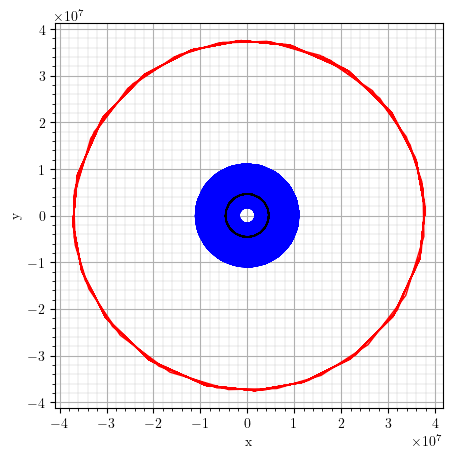

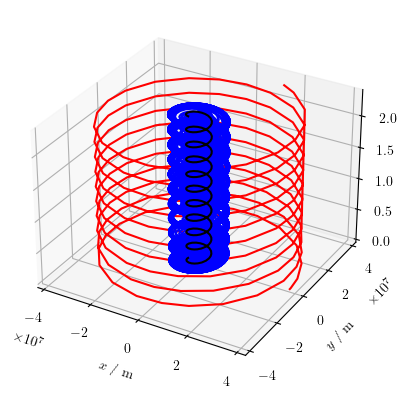

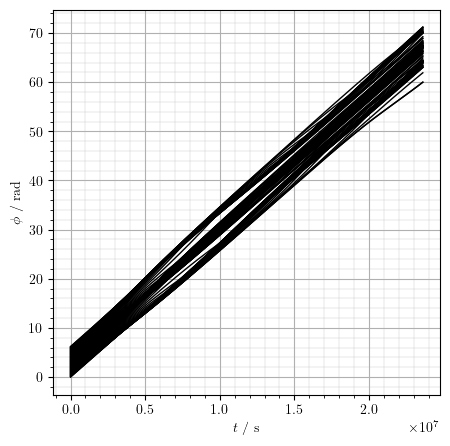

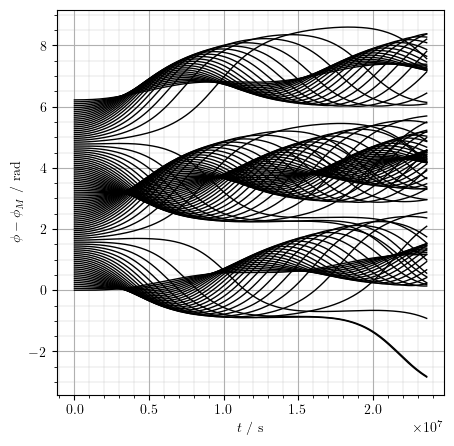

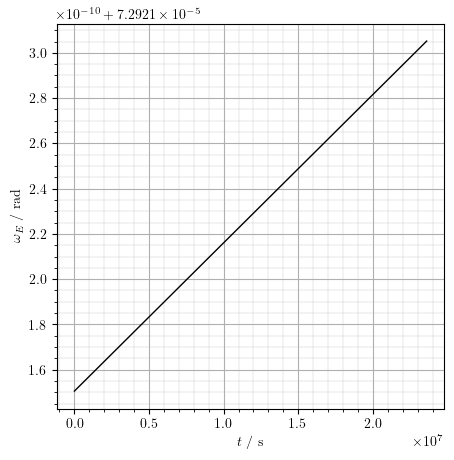

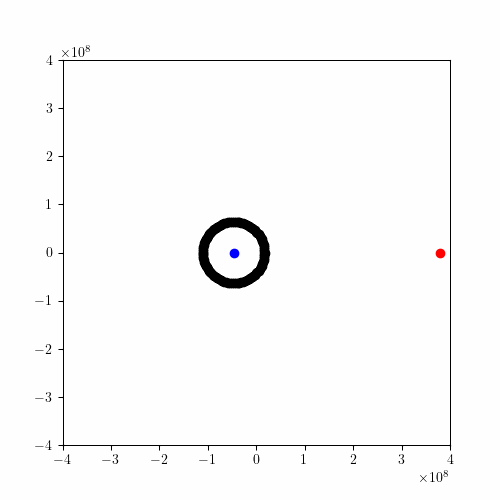

In [46]:
# Cartesian coordinates of the tides:
x_i = [x_E + RErde*np.cos(phi[i]) for i in range(N)]
y_i = [y_E + RErde*np.sin(phi[i]) for i in range(N)]

plt.rc('axes', axisbelow=True)
plt.figure(figsize=(5, 5))
plt.grid('minor', 'minor', linestyle='-', linewidth=0.2)
plt.grid('major', 'major', linestyle='-', linewidth=0.8)
plt.minorticks_on()
plt.xlabel("x")
plt.ylabel("y")

plt.plot(x_M/10, y_M/10, 'r', linewidth=1, label='Mond (/10)')
for i in range(N):
    plt.plot(x_i[i], y_i[i], 'b', linewidth=1, label=f'Flutberg {i+1}')
plt.plot(x_E, y_E, 'k', linewidth=1, label='Erde')

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt.close()


# Plot a 3d phase space diagram
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.plot(x_M/10, y_M/10, t, 'r', label='Mond')
for i in range(N):
    ax.plot(x_i[i], y_i[i], t, 'b', label=f'Flutberg {i+1}')
ax.set_xlabel("$x$ / m")
ax.set_ylabel("$y$ / m")
ax.set_zlabel("$t$ / s")
ax.plot(x_E, y_E, t, 'k', label='Erde')

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt.close()

# Plot the angles of the tides over time
plt.rc('axes', axisbelow=True)
plt.figure(figsize=(5, 5))
plt.grid('minor', 'minor', linestyle='-', linewidth=0.2)
plt.grid('major', 'major', linestyle='-', linewidth=0.8)
plt.minorticks_on()
plt.xlabel("$t$ / s")
plt.ylabel("$\phi$ / rad")

for i in range(N):
    plt.plot(t, phi[i], 'k', linewidth=1, label=f'Flutberg {i+1}')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt.close()

# Plot the angles of the tides over time, subtracting the angle of the moon
plt.rc('axes', axisbelow=True)
plt.figure(figsize=(5, 5))
plt.grid('minor', 'minor', linestyle='-', linewidth=0.2)
plt.grid('major', 'major', linestyle='-', linewidth=0.8)
plt.minorticks_on()
plt.xlabel("$t$ / s")
plt.ylabel("$\phi - \phi_M$ / rad")

for i in range(N):
    plt.plot(t, phi[i] - t*2*pi/TMondBahn, 'k', linewidth=1, label=f'Flutberg {i+1}')

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
plt.close()

plt.rc('axes', axisbelow=True)
plt.figure(figsize=(5, 5))
plt.grid('minor', 'minor', linestyle='-', linewidth=0.2)
plt.grid('major', 'major', linestyle='-', linewidth=0.8)
plt.minorticks_on()
plt.xlabel("$t$ / s")
plt.ylabel("$\omega_E$ / rad")
plt.plot(t, omega_E, 'k', linewidth=1, label='$\omega_E$')

# plt.legend()
plt.show()
plt.close()

# Animation of the N body problem
if not fastExecution: # Don't render if not necessary
    fig = plt.figure(figsize=(5, 5)) # Square figure, so the circles are actually circles
    ax = plt.axes(xlim=(-4e8, 4e8), ylim=(-4e8, 4e8))
    earth_line, = ax.plot([], [], marker='o', lw=0.1, color='blue', label='Erde (*10)')
    moon_line, = ax.plot([], [], marker='o', lw=0.1, color='red', label='Mond')
    tide_lines = [ax.plot([], [], marker='o', lw=0.1, color='black', label='Flutberg {i} (*10)')[0] for i in range(N)]
    # ax.legend()

    def animate(i):
        earth_line.set_data([x_E[i]*10], [y_E[i]*10])
        moon_line.set_data([x_M[i]], [y_M[i]])
        for j in range(N):
            tide_lines[j].set_data([x_i[j][i]*10], [y_i[j][i]*10])
        return earth_line, moon_line, *tide_lines

    anim = FuncAnimation(fig, animate, init_func=None, frames=t.shape[0], interval=30, blit=True)
    anim.save('Erde_Mond_NFlutberge.gif', writer='pillow')
    plt.close()

display(Image(data=open('Erde_Mond_NFlutberge.gif','rb').read(), format='png'))